In [165]:
%rm -rf spam_dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [ ]:
# Unpack the data
data = pd.read_csv("Titanic-Dataset.csv")
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
data["Age"]

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,NaN
889,26.0


In [ ]:
# Fill the missing values in "Age" column
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

data["Age"] = imputer.fit_transform(pd.DataFrame(data["Age"]))

In [ ]:
data["Sex"].value_counts()

,count
Sex,
male,577
female,314


In [ ]:
data["Embarked"].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [ ]:
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [ ]:
# Drop unique values columns
data.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

In [ ]:
# Encode the sex and embarked and standardize the num values
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OrdinalEncoder())

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                            StandardScaler())

cat_data = ["Sex", "Embarked"]
num_data = ["Age", "Fare"]

preprocessing = ColumnTransformer([("cat", cat_pipeline, cat_data),
                                  ("num", num_pipeline, num_data)], remainder="passthrough")

In [ ]:
transformed = preprocessing.fit_transform(data)
transformed_data = pd.DataFrame(transformed, columns=preprocessing.get_feature_names_out())
transformed_data.head(2)

,cat__Sex,cat__Embarked,num__Age,num__Fare,remainder__PassengerId,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch
0,1.0,2.0,-0.592481,-0.502445,1.0,0.0,3.0,1.0,0.0
1,0.0,0.0,0.638789,0.786845,2.0,1.0,1.0,1.0,0.0


In [ ]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat__Sex                891 non-null    float64
 1   cat__Embarked           891 non-null    float64
 2   num__Age                891 non-null    float64
 3   num__Fare               891 non-null    float64
 4   remainder__PassengerId  891 non-null    float64
 5   remainder__Survived     891 non-null    float64
 6   remainder__Pclass       891 non-null    float64
 7   remainder__SibSp        891 non-null    float64
 8   remainder__Parch        891 non-null    float64
dtypes: float64(9)
memory usage: 62.8 KB


In [ ]:
# Find some correlations
transformed_data.corr()["remainder__Survived"]

,remainder__Survived
cat__Sex,-0.543351
cat__Embarked,-0.167675
num__Age,-0.069809
num__Fare,0.257307
remainder__PassengerId,-0.005007
remainder__Survived,1.000000
remainder__Pclass,-0.338481
remainder__SibSp,-0.035322
remainder__Parch,0.081629


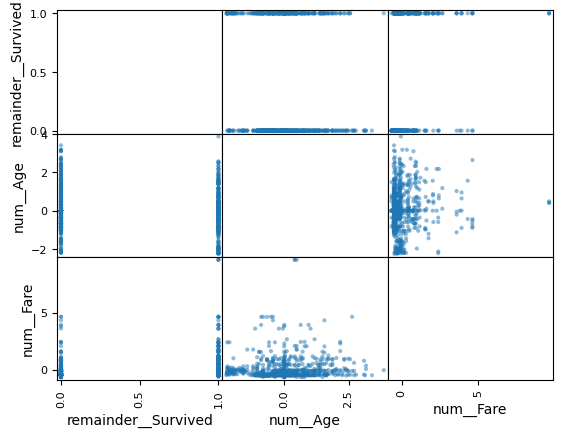

In [ ]:
from pandas.plotting import scatter_matrix
columns = ["remainder__Survived", "num__Age", "num__Fare"]
scatter_matrix(transformed_data[columns], diagonal=False)
plt.show()

In [ ]:
# Separate the data into train and test sets
from sklearn.model_selection import StratifiedShuffleSplit

X = transformed_data.drop(columns=["remainder__Survived"])
y = transformed_data["remainder__Survived"]

ssp = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

variations = []

for train_indices, test_indices in ssp.split(X, y):
  train = transformed_data.iloc[train_indices]
  test = transformed_data.iloc[test_indices]
  variations.append([train, test])

In [ ]:
train_set, test_set = variations[0]

In [ ]:
# Split the data into X and y

X_train = train_set.drop(columns=["remainder__Survived"])
y_train = train_set["remainder__Survived"]

X_test = test_set.drop(columns=["remainder__Survived"])
y_test = test_set["remainder__Survived"]

In [ ]:
# Use randomized search for SVC
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
              "degree": [1, 2, 3], "C": [1, 2]}

random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=5, scoring='neg_root_mean_squared_error', cv=3)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=5,
                   param_distributions={'C': [1, 2], 'degree': [1, 2, 3],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='neg_root_mean_squared_error')

In [ ]:
svc_model = random_search.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(svc_model, X_train, y_train, cv=3)

array([0.84033613, 0.77637131, 0.8185654 ])

In [ ]:
svc_model.fit(X_train, y_train)

SVC(C=2, degree=2, kernel='linear')

In [ ]:
y_preds = svc_model.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

print(f"Accuracy: {accuracy_score(y_test, y_preds) * 100:.0f}%")
print(f"Precision: {precision_score(y_test, y_preds):.4f}")
print(f"Recall: {recall_score(y_test, y_preds):.4f}")
print(f"F1: {f1_score(y_test, y_preds):.4f}")

Accuracy: 72%
Precision: 0.6727
Recall: 0.5362
F1: 0.5968


In [ ]:
y_scores = svc_model.decision_function(X_train)

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
recall_70_index = np.argmax((recall > 0.8))
threshold_70_recall = thresholds[recall_70_index]

recall_score(y_train, (y_scores > threshold_70_recall))

1.0

# Spam classifier

In [ ]:
tarfile.open(requests.get(ham_url).content)

ValueError: embedded null byte

In [ ]:
import urllib
tarfile.open("content\spam.bz2")

In [166]:
# Download the datasets
import tarfile
import requests
import pathlib
from pathlib import Path
import urllib
import os

spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
ham_url = spam_root + "20030228_easy_ham.tar.bz2"
spam_url = spam_root + "20030228_spam.tar.bz2"

dataset_dir = Path("/content/spam_dataset")

if not dataset_dir.is_dir():
  os.mkdir(dataset_dir)

urllib.request.urlretrieve(spam_url, dataset_dir / "/spam.tar.bz2")
spam = tarfile.open(dataset_dir / "/spam.tar.bz2")
spam.extractall(path=dataset_dir)

urllib.request.urlretrieve(ham_url, dataset_dir / "/ham.tar.bz2")
spam = tarfile.open(dataset_dir / "/ham.tar.bz2")
spam.extractall(path=dataset_dir)

In [167]:
spam_filenames = [f for f in Path(dataset_dir / "spam").iterdir() if f != ".ipynb_checkpoints"]
ham_filenames = [f for f in Path(dataset_dir/"easy_ham").iterdir() if f != ".ipynb_checkpoints"]

In [168]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [169]:
hams = [load_email(ham) for ham in ham_filenames]
spams = [load_email(spam) for spam in spam_filenames]

In [176]:
spams, hams

'<html>\n<body>\n<p>67% of women desire a &quot;bigger&quot; man...<br>\n>>From the Creator of Longitude comes SizeMAX-<br>\nThe most powerful penis enlargement pill on the market!<br>\n<br>\nGO BIG... SATISFY HER BETTER THAN ANY MAN CAN!!!<br>\nOVER 120,000,000 CAPSULES SOLD!!!<br>\n<br>\n. Do you want a larger and firmer penis?<br>\n. Do you want to give your partner more pleasure?<br>\n. Do you want to stay ROCK HARD longer? <br>\n<br>\nOur Revolutionary Pill Can Enlarge Your Penis<br>\nUp to 3-FULL-INCHES. 100% GUARANTEED! <br>\n<br>\nBelieve it or not, it is now possible.<br>\nCheck out dramatic before and after photos and what JANE Magazine had to<br>\nsay about the breakthrough SizeMAX formula...<br>\n<br>\n<b><a href="http://218.5.77.248/www418/"><font size="5">CLICK HERE</font></a></b></p>\n<p>&nbsp;</p>\n<p>&nbsp;</p>\n<p><font size="2">for no further emails <a href="http://218.5.77.248/www418/takemeoff.html">click here</a></font></p>\n</body>\n</html>\n\n [^":}H&*TG0BK5NKIYs

In [184]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(hams + spams, dtype=object)
y = np.array([0] * len(hams) + [1] * len(spams))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [238]:
from sklearn.pipeline import make_pipeline
from nltk.stem import PorterStemmer
from sklearn.base import TransformerMixin, BaseEstimator

class LowerCase(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X=None):
    return np.array([i.get_content().lower() for i in X])

class Stemmer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X=None):
    for i in X:
      for j in i:
        PorterStemmer().stem(word=j)
    return X

# def stemmer(mail):
#  return str(PorterStemmer.stem(i) for i in mail.split)

# def num_2_str(mail):
#  return mail.translate((str.maketrans("0123456789", "NUMBER" * 10)))

email_pipeline = make_pipeline(LowerCase(), Stemmer())

In [239]:
email_pipeline.fit_transform(X_train[:5])[3]

np.str_('url: http://boingboing.net/#85505975\ndate: not supplied\n\n[img: http://www.craphound.com/images/electricball.jpg] stefan sez: "my \nbrother\'s friend sue plays with high voltage. the linked-to page shows the \ngadget she used to photograph high voltage discharges in *water*." link[1] \ndiscuss[2] (_thanks, stefan!_) \n\n\n[1] http://community.webshots.com/album/8426665gzkjeytine\n[2] http://www.quicktopic.com/boing/h/uzustbtspq7k\n\n\n')

In [207]:
X_train[1].get_content()

'Once upon a time, Ville wrote :\n\n> Any plans for rolling Nessus RPMs for RH8?  Miss it already...\n\nWell, that\'s one of the 10 rpm-related mails leftover in my inbox I just\nmentionned privately ;-)\nAs it\'s a big piece and needs some testing, I\'m just bit lazy about it :-/\n\nI\'ll try to packages it asap, or at least put up a "testing" version first\nin case I fear some imperfections.\n\nMatthias\n\n-- \nClean custom Red Hat Linux rpm packages : http://freshrpms.net/\nRed Hat Linux release 7.3 (Valhalla) running Linux kernel 2.4.18-10acpi\nLoad : 0.17 0.17 0.12\n\n_______________________________________________\nRPM-List mailing list <RPM-List@freshrpms.net>\nhttp://lists.freshrpms.net/mailman/listinfo/rpm-list\n\n\n'